# GitHub analysis client
This notebook assumes that Pulsar is running and there are already partial results available

In [88]:
import matplotlib.pyplot as plt
import time
import operator
import pulsar
import _pulsar
from pulsar import PartitionsRoutingMode
from pulsar import MessageId
import os
import pandas as pd
import sortedcontainers
from pulsar_wrapper import PulsarConnection

ModuleNotFoundError: No module named 'pulsar_wrapper'

In [66]:
# Take Pulsar host value from the environment variables
environment = os.environ
pulsar_host = environment.get("pulsar_host")
# If not set, assume its running in localhost
if (pulsar_host is None): pulsar_host = 'localhost'
my_pulsar = PulsarConnection(ip_address=pulsar_host)

In [67]:
def get_current_cuttoff_date():
    """ Receives the 'YYYY-MM-DD' of the last processed information. If 
    it is '2021-12-31' it means all has already been processed """    
    client = pulsar.Client(f'pulsar://{pulsar_host}:6650')
    
    # This info is kept in the 'initialized' topic
    init_topic = 'initialized'
    curr_time = str(int(time.time()))
    try:
        reader = client.create_reader(
            topic=f"persistent://public/static/{init_topic}",
            reader_name=f'{init_topic}_sub_{curr_time}',
            start_message_id=MessageId.earliest)
    except Exception as e:
        print(f"\n*** Exception creating reader for 'initialized' topic: {e} ***\n")
        return

    message_list = []
    while reader.has_message_available():
        try:
            # Give up to 400 milliseconds to receive an answer
            msg = reader.read_next(timeout_millis=400)
            # Save the string message (decode from byte value)
            message_list.append(str(msg.value().decode()))
        except Exception as e:
            print(f"\n*** Exception receiving value from 'initialized' topic: {e} ***\n")
            break
    reader.close()
    client.close()
    
    return message_list[-1]

In [68]:
def get_top_commits(num_values):
    """ Function to fetch the top num_values commit results. It assumes messages are
    ordered and in the tuple format: (id_repo, num_commits, 'repo_owner', 'repo_name').
    It returns a num_values list of tuples of the form ('repo_name', num_commits) """
    
    client = pulsar.Client(f'pulsar://{pulsar_host}:6650')
    
    curr_time = str(int(time.time()))
    cutoff_date = get_cuttoff_date()
    
    # Check if there are available results. cutoff_date should have
    # length 10 string ('YYYY-MM-DD')
    if (len(cutoff_date) != 10):
        print(f"It seems there are still no results. Received '{cutoff_date}' as cutoff value")
        return

    if (cutoff_date == '2021-12-31'):
        print("\n*** Showing final results (all info has been processed) ***\n")
    else:
        print(f"\n*** Showing partial results up to {cutoff_date} (info is still being processed) ***\n")
    
    # The results are kept in the {cutoff-date}_result_commit' topic
    topic_name = f'{cutoff_date}_result_commit'
    curr_time = str(int(time.time()))
    try:
        reader = client.create_reader(
            topic=f"persistent://public/static/{topic_name}",
            reader_name=f'{init_topic}_sub_{curr_time}',
            start_message_id=MessageId.earliest)
    except Exception as e:
        print(f"\n*** Exception creating reader for 'initialized' topic: {e} ***\n")
        reader.close()
        return

    result_list = []
    while (reader.has_message_available() and len(result_list)<num_values):
        try:
            # Give up to 400 milliseconds to receive an answer
            msg = reader.read_next(timeout_millis=400)
            # Save the string message (decode from byte value)
            result_tuple = eval(str(msg.value().decode()))
            repo_name = f"{result_tuple[2]}/{result_tuple[3]}"
            result_list.append((repo_name, result_tuple[1]))
        except Exception as e:
            print(f"\n*** Exception receiving value from 'initialized' topic: {e} ***\n")
            break
    reader.close()
    client.close()
    
    return result_list

In [85]:
def get_languages_stats():
    """ Receives current aggregated information of languages in a list made of tuples
    ('language', num_repos, num_tests, num_cis). Returns a dictionary with the consolidated
    information, with language as key"""
    
    client = pulsar.Client(f'pulsar://{pulsar_host}:6650')
    
    curr_time = str(int(time.time()))
    
    # The results are kept in the 'public/static/language_results' topic
    topic_name = 'language_results'
    curr_time = str(int(time.time()))
    try:
        reader = client.create_reader(
            topic=f"persistent://public/static/{topic_name}",
            reader_name=f'{init_topic}_sub_{curr_time}',
            start_message_id=MessageId.earliest)
    except Exception as e:
        print(f"\n*** Exception creating reader for 'language_results' topic: {e} ***\n")
        reader.close()
        return

    result_dict = {}
    while reader.has_message_available():
        try:
            # Give up to 400 milliseconds to receive an answer
            msg = reader.read_next(timeout_millis=400)
            # Save the string message (decode from byte value)
            result_tuple = eval(str(msg.value().decode()))
            result_dict[result_tuple[0]]={'num_repos': result_tuple[1],
                              'num_tests': result_tuple[2],
                              'num_ci': result_tuple[3]}
        except Exception as e:
            print(f"\n*** Exception receiving value from 'initialized' topic: {e} ***\n")
            break
    reader.close()
    client.close()
    
    return result_dict
    

In [63]:
# Function to plot the results
def plot_dict(result_list, title='', xlabel='', ylabel=''):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)

    ax.set_ylabel(ylabel)
    ax.set_title(title)

    top_languages = dict(sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True))
    x_axis = list(top_languages.keys())
    y_axis = list(top_languages.values())
    plt.bar(range(len(top_languages)), y_axis, tick_label=x_axis)
    plt.show()

In [ ]:
results = get_top_commits(100)

In [86]:
result_dict = get_languages_stats()

2022-06-01 14:56:51.231 INFO  [140429562840896] ClientConnection:189 | [<none> -> pulsar://localhost:6650] Create ClientConnection, timeout=10000
2022-06-01 14:56:51.231 INFO  [140429562840896] ConnectionPool:96 | Created connection for pulsar://localhost:6650
2022-06-01 14:56:51.236 INFO  [140428359747328] ClientConnection:375 | [127.0.0.1:57420 -> 127.0.0.1:6650] Connected to broker
2022-06-01 14:56:51.246 INFO  [140428359747328] HandlerBase:64 | [persistent://public/static/language_results, reader-a0ed2a2765, 0] Getting connection from pool
2022-06-01 14:56:51.250 INFO  [140428359747328] ConsumerImpl:224 | [persistent://public/static/language_results, reader-a0ed2a2765, 0] Created consumer on broker [127.0.0.1:57420 -> 127.0.0.1:6650] 
2022-06-01 14:56:51.261 INFO  [140429562840896] ConsumerImpl:999 | [persistent://public/static/language_results, reader-a0ed2a2765, 0] Closing consumer for topic persistent://public/static/language_results
2022-06-01 14:56:51.263 INFO  [14042835974732

In [87]:
result_dict

{'9language_511': {'num_repos': None, 'num_tests': None, 'num_ci': None},
 '9language_512': {'num_repos': None, 'num_tests': None, 'num_ci': None},
 '9language_513': {'num_repos': None, 'num_tests': None, 'num_ci': None},
 'language1': {'num_repos': 2, 'num_tests': None, 'num_ci': None},
 'language2': {'num_repos': 2, 'num_tests': None, 'num_ci': None},
 'language3': {'num_repos': 2, 'num_tests': None, 'num_ci': None}}

In [79]:
test_tuple2 = "('c', 31, 21, 19)"
result_tuple = eval(test_tuple2)
result_dict[result_tuple[0]]={'num_repos': result_tuple[1],
                              'num_tests': result_tuple[2],
                              'num_ci': result_tuple[3]}

In [80]:
result_dict

{'python': {'num_repos': 30, 'num_tests': 25, 'num_ci': 20},
 'c': {'num_repos': 31, 'num_tests': 21, 'num_ci': 19}}

# 1. Top programming languages based on the number of projects developed

In [59]:
pd.DataFrame(results, columns=['Repository name','Number of commits'])

,Repository name,Number of commits
0,owner_3/repo_3,26
1,owner_2/repo_2,21
2,owner_1/repo_1,16


2022-05-23 08:47:21.824 INFO  [140256519571264] Client:88 | Subscribing on Topic :persistent://public/default/top_languages
2022-05-23 08:47:21.824 INFO  [140256519571264] ClientConnection:189 | [<none> -> pulsar://localhost:6650] Create ClientConnection, timeout=10000
2022-05-23 08:47:21.824 INFO  [140256519571264] ConnectionPool:96 | Created connection for pulsar://localhost:6650
2022-05-23 08:47:21.832 INFO  [140255600891648] ClientConnection:375 | [127.0.0.1:46550 -> 127.0.0.1:6650] Connected to broker
2022-05-23 08:47:21.836 INFO  [140255600891648] HandlerBase:64 | [persistent://public/default/top_languages, top_languages_sub_1653295641, 0] Getting connection from pool
2022-05-23 08:47:22.247 INFO  [140255600891648] ConsumerImpl:224 | [persistent://public/default/top_languages, top_languages_sub_1653295641, 0] Created consumer on broker [127.0.0.1:46550 -> 127.0.0.1:6650] 

*** Reached end of values ***

2022-05-23 08:47:22.280 INFO  [140256519571264] ClientImpl:496 | Closing Puls

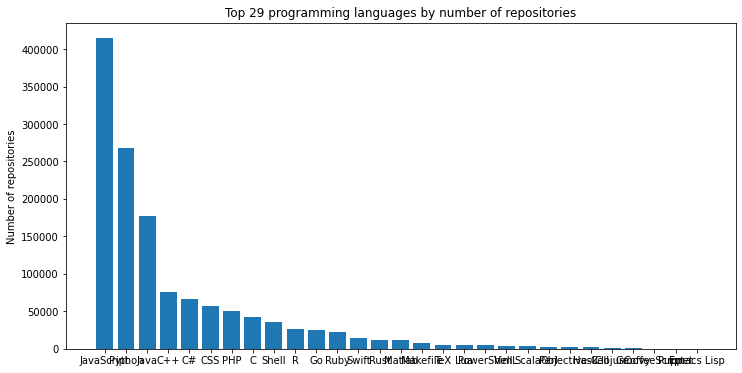

In [48]:
# Define the number of top languages to return, get the results, and plot them
num_results = 100

q1_list = get_top_commits(num_results)

returned_results = len(q1_dict)
plot_dict(q1_dict, 
          title=f'Top {returned_results} programming languages by number of repositories', 
          xlabel='', ylabel='Number of repositories')

# 2. Repositories with most commits

# 3. Top languages with testdriven approach

# 4. Top languages with testdriven approach and continous integration

In [6]:
my_var = 'pepe_host'
def test_function():
    # Take Pulsar host value from the environment variables
    environment = os.environ
    pulsar_host = environment.get("pulsar_host")
    # If not set, assume its running in localhost
    if (pulsar_host is None): pulsar_host = my_var
    print(pulsar_host)

In [7]:
test_function()

pepe_host


In [5]:
environment = os.environ
print(environment.get("pulsar_host"))

None


In [12]:
cut = '2021-01-01'
len(cut)

10